In [95]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [96]:
df_HCC_Train = pd.read_csv("raw_data/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_HCC_Train))

df_HCC_Test = pd.read_csv("raw_data/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt",delimiter="\ ",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_HCC_Test))

df_MCF_Train = pd.read_csv("raw_data/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter="\ ",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_HCC_Train))

df_MCF_Test = pd.read_csv("raw_data/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt",delimiter="\ ",engine='python',index_col=0)
print("Dataframe dimensions:", np.shape(df_HCC_Test))


Dataframe dimensions: (3000, 182)
Dataframe dimensions: (3000, 45)
Dataframe dimensions: (3000, 182)
Dataframe dimensions: (3000, 45)


In [97]:
#given a dataset it returns a list will all the values of the targets (hypo = 0 and Norm = 0)
def labels(df):
    target = []
    for c in df.columns:
        if "Hypoxia" in c.split("_") or "Hypo" in c.split("_"):
            target.append(0.0)
        elif "Normoxia" in c.split("_") or "Norm" in c.split("_"):
            target.append(1.0)
        else:
            raise ValueError("Cell cannot be categorized")
    return target
        

Function that given a epsilon (between 0 and 1) tells you how many PCA components to take so that you have the total explained variance at least epilon

In [98]:
from sklearn.decomposition import PCA

def numb_pca_comp(df, eps = 0.95):
    if eps < 0 or eps > 1:
        raise TypeError("Epsilon has to be between 0 and 1")
    pca_temp = PCA()
    pca_temp.fit(df)
    counter = 0
    total_var = 0
    for var in pca_temp.explained_variance_ratio_:
        counter += 1
        if total_var + var > eps:
            return counter
        total_var = total_var + var
        continue

numb_pca_comp(df_MCF_Train.T)
numb_pca_comp(df_HCC_Train.T)

34

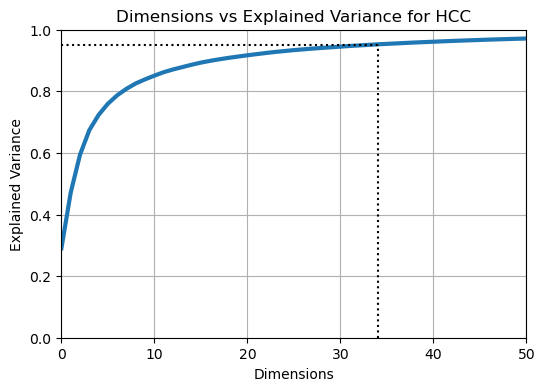

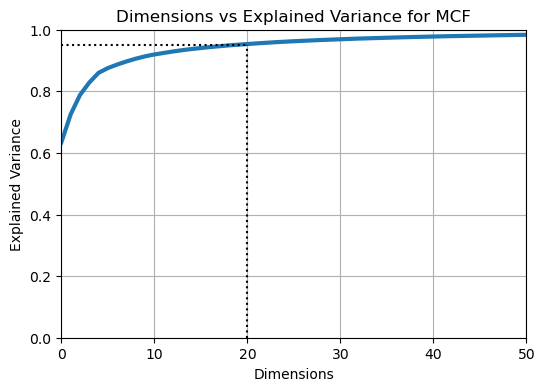

In [99]:
##-----------------HCC-----------------##
c_HCC = numb_pca_comp(df_HCC_Train.T)
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(PCA().fit(df_HCC_Train.T).explained_variance_ratio_), linewidth=3)
plt.axis([0, 50, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([c_HCC, c_HCC], [0, 0.95], "k:")
plt.plot([0, c_HCC], [0.95, 0.95], "k:")
plt.title("Dimensions vs Explained Variance for HCC")
plt.grid(True)
plt.show()

##-----------------MCF-----------------##
c_MCF = numb_pca_comp(df_MCF_Train.T)
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(PCA().fit(df_MCF_Train.T).explained_variance_ratio_), linewidth=3)
plt.axis([0, 50, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([c_MCF, c_MCF], [0, 0.95], "k:")
plt.plot([0, c_MCF], [0.95, 0.95], "k:")
plt.title("Dimensions vs Explained Variance for MCF")
plt.grid(True)
plt.show()

Grid search to find optimal amount of PCA components

In [100]:
from sklearn.linear_model import SGDClassifier #Stocastic Gradient decent
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_for_grid = {"pca__n_components": np.arange(10, 80)}

##-----------------HCC-----------------##
grid_search_HCC = GridSearchCV(clf, param_for_grid, cv=3)
grid_search_HCC.fit(df_HCC_Train.T, labels(df_HCC_Train))
print(grid_search_HCC.best_params_)

##-----------------MCF-----------------##
grid_search_MCF = GridSearchCV(clf, param_for_grid, cv=3)
grid_search_MCF.fit(df_MCF_Train.T, labels(df_MCF_Train))
print(grid_search_MCF.best_params_)

{'pca__n_components': 38}
{'pca__n_components': 20}


Make PCA with number of components returned by the function

In [101]:
##-----------------HCC-----------------##
pca_HCC = PCA(n_components=numb_pca_comp(df_HCC_Train.T))
pca_HCC.fit(df_HCC_Train.T)
print(pca_HCC.explained_variance_ratio_.sum())
df_HCC_Train_small = pca_HCC.fit_transform(df_HCC_Train.T)

##-----------------MCF-----------------##
pca_MCF = PCA(n_components=numb_pca_comp(df_MCF_Train.T))
pca_MCF.fit(df_MCF_Train.T)
print(pca_MCF.explained_variance_ratio_.sum())
df_MCF_Train_small = pca_MCF.fit_transform(df_MCF_Train.T)


0.9508054791496121
0.9514417354504584


Make PCA with number of components returned by grid search

In [102]:
##-----------------HCC-----------------##
pca_HCC_grid = PCA(n_components=grid_search_HCC.best_params_['pca__n_components'])
pca_HCC_grid.fit(df_HCC_Train.T)
print(pca_HCC_grid.explained_variance_ratio_.sum())
df_HCC_Train_grid_small = pca_HCC_grid.fit_transform(df_HCC_Train.T)

##-----------------MCF-----------------##
pca_MCF_grid = PCA(n_components=grid_search_MCF.best_params_['pca__n_components'])
pca_MCF_grid.fit(df_MCF_Train.T)
print(pca_MCF_grid.explained_variance_ratio_.sum())
df_MCF_Train_grid_small = pca_MCF_grid.fit_transform(df_MCF_Train.T)

0.9570787888214758
0.95144139143295
